# Entropy #

Date : 28/05/2018 <br>
Author : SL  <br>
Code : https://github.com/bosscha/alma

## Scope

Tests on different array configurations measuring the entropy on the images.
We use the method of Mutual information with the Joint Entropy between the initial image convolved to the spatial resolution and simulated one.
Eventually we could use the original image...
A short description of the method can be found in http://en.wikipedia.org/wiki/Mutual_information <br>
Python code adapted from:  https://matthew-brett.github.io/teaching/mutual_information.html <br>
<br>
Simulations produced by *runSimulationEntropy.py*

In [10]:
import os, shutil , glob
import matplotlib.pyplot as pl
from pylab import rcParams
import numpy as np
import math
from sklearn.metrics import mutual_info_score
from numpy import unique
from scipy.stats import entropy as scipy_entropy


from astropy.io import fits
from astropy.stats import histogram
from astropy.wcs import WCS

%matplotlib inline


In [11]:
def shannon_entropy(image, base=np.e):
    """Calculate the Shannon entropy of an image.
    The Shannon entropy is defined as S = -sum(pk * log(pk)),
    where pk are frequency/probability of pixels of value k.
    
    Notes
    -----
    The returned value is measured in bits or shannon (Sh) for base=2, natural
    unit (nat) for base=np.e and hartley (Hart) for base=10. """
    
    _, counts = unique(image, return_counts=True)
    return scipy_entropy(counts, base=base)

In [12]:
## sklearn implementation
def calc_MI_sk(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [13]:
def MutualInformation(im1, im2, binsize = 20):
    "Compute the mutual information between im1 and im2"
    
    
    hgram, x_edges, y_edges = np.histogram2d(im1.ravel(), im2.ravel(), bins = binsize)
    
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
    
    return(mi)

In [14]:
## Analysis function

def analysis_image(index, caption, mibin=20):
    
    model1 = "AFC-%d.alma.afc-%d.skymodel.flat.regrid.conv.fits"%(index, index)
    sim1   = "AFC-%d.alma.afc-%d.image.fits"%(index, index)
        
    with fits.open(model1) as m1:
        in1 = m1[0].data
        
    with fits.open(sim1) as s1:
        out1 = s1[0].data 
        
    mi1 = MutualInformation(in1, out1, mibin)   
    mi1sk   = calc_MI_sk(in1.ravel(), out1.ravel(), mibin)

    
    model2 = "C43-%d+ACA.concat.skymodel.flat.regrid.conv.fits"%(index)
    sim2  =  "C43-%d+ACA.concat.image.fits"%(index)
    
    with fits.open(model2) as m2:
        in2 = m2[0].data
        
    with fits.open(sim2) as s2:
        out2 = s2[0].data 
        
    mi2 = MutualInformation(in2, out2, mibin) 
    mi2sk   = calc_MI_sk(in2.ravel(), out2.ravel(), mibin)

    
    ## ---------------------------
    
    print(r"## (mutual information): AFC-%d"%(index))
    print("## MI1 : %f  %f"%(mi1, mi1sk))
    print("")
    print(r"## (mutual information): C43-%d+ACA"%(index))
    print("## MI2 : %f %f"%(mi2, mi2sk))
    print("##")
    print("## (the higher the better)")
    print("")
    

In [15]:
def compute_miconfiguration(projId, type = 1):
    "Compute the mi on one configuration for all fits."
    
    if type == 1:
        project = "AFC-%d"%(projId)
    if type == 2:
        project = "C43-%d+ACA"%(projId)
        
    found = False
    index = 0
    
    if type == 1:
        model1 = "%s.alma.afc-%d.compskymodel.flat.regrid.conv.fits.%d"%(project, projId, index)
        ori1  = "%s.alma.afc-%d.compskymodel.flat.regrid.fits.%d"%(project, projId, index)
        sim1   = "%s.alma.afc-%d.image.fits.%d"%(project, projId, index)
    if type == 2:
        sim1 = "C43-%d+ACA.concat.image.fits.%d"%(projId, index)
        model1 = "C43-%d+ACA.concat.compskymodel.flat.regrid.conv.fits.%d"%(projId, index)
        ori1  ="C43-%d+ACA.concat.compskymodel.flat.regrid.fits.%d"%(projId, index)
    
    if  os.path.exists(model1):
        found = True
        
    miArr    = []
    miOriArr = []
    shanArr  = []
    
    while(found):
        with fits.open(model1) as m1:
            in1 = m1[0].data
        
        with fits.open(sim1) as s1:
            out1 = s1[0].data 
            
        with fits.open(ori1) as o1:
            orig1 = o1[0].data
            orig1[ orig1 < 1e-15] = 0.
        
        
        mi     = MutualInformation(in1 , out1)
        mi_ori = MutualInformation(orig1 , out1)
        shan   = shannon_entropy(in1.ravel())
        
        miArr.append(mi)
        miOriArr.append(mi_ori)
        shanArr.append(shan)
        
        index += 1
        if type == 1:
            model1 = "%s.alma.afc-%d.compskymodel.flat.regrid.conv.fits.%d"%(project, projId, index)
            ori1  = "%s.alma.afc-%d.compskymodel.flat.regrid.fits.%d"%(project, projId, index)
            sim1   = "%s.alma.afc-%d.image.fits.%d"%(project, projId, index)
        if type == 2:
            sim1 = "C43-%d+ACA.concat.image.fits.%d"%(projId, index)
            model1 = "C43-%d+ACA.concat.compskymodel.flat.regrid.conv.fits.%d"%(projId, index)
            ori1  = "C43-%d+ACA.concat.compskymodel.flat.regrid.fits.%d"%(projId, index)
    
        if  os.path.exists(model1):
            found = True
        else:
            found = False
            
    miArrRes = np.zeros(len(miArr))
    miArrRes[0:len(miArr)] = miArr
    
    shanArrRes = np.zeros(len(shanArr))
    shanArrRes[0:len(shanArr)] = shanArr
    
    miOriArrRes = np.zeros(len(miOriArr))
    miOriArrRes[0:len(miOriArr)] = miOriArr
        
    return(miArrRes, miOriArrRes, shanArrRes)
    

In [16]:
### compute stats on MI
def mi_stats():
    
    mi_afc = {}
    mi_c43  = {}
    
    mi_afc['MI']  = []
    mi_afc['MIStd'] = []
    mi_afc['MIori']  = []
    mi_afc['MIoriStd'] = []
    mi_afc['Shannon'] = []
    mi_afc['ShanStd'] = []
    
    mi_c43['MI']  = []
    mi_c43['MIStd'] = []
    mi_c43['MIori']  = []
    mi_c43['MIoriStd'] = []
    mi_c43['Shannon'] = []
    mi_c43['ShanStd'] = []
    
    for i in range(1,7):
        mi , mi_ori, shan = compute_miconfiguration(i, 1)
        
        mi_afc['MI'].append(mi.mean())
        mi_afc['MIStd'].append(mi.std())
        mi_afc['MIori'].append(mi_ori.mean())
        mi_afc['MIoriStd'].append(mi_ori.std())
        mi_afc['Shannon'].append(shan.mean())
        mi_afc['ShanStd'].append(shan.std())
        
        mi, mi_ori, shan = compute_miconfiguration(i, 2)
        mi_c43['MI'].append(mi.mean())
        mi_c43['MIStd'].append(mi.std())
        mi_c43['MIori'].append(mi_ori.mean())
        mi_c43['MIoriStd'].append(mi_ori.std())        
        mi_c43['Shannon'].append(shan.mean())
        mi_c43['ShanStd'].append(shan.std())
        
    return(mi_afc, mi_c43)

### Analysis ....
----------------------

In [17]:
# wdir = "/home/stephane/Science/ALMA/ArrayConfig/imaging/fullcombination/simEntropy/products"
#wdir = "/home/stephane/alma/ArrayConfig/imaging/fullcombination/simEntropy/products"
wdir = "/home/stephane/Science/ALMA/ArrayConfig/imaging/fullcombination/simulationEntropy/products"
os.chdir(wdir)

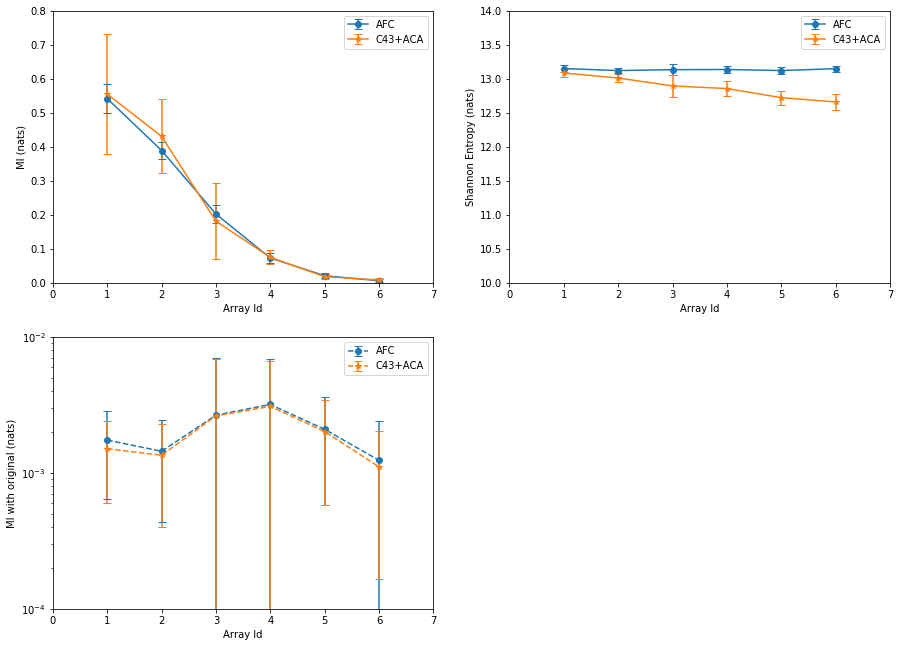

In [18]:
## Compute the MI entropy on several mock images for the two types of configuration and plot the results.
##

afc , c43 = mi_stats()

    
rcParams['figure.figsize'] = 15, 11.0
xx = range(1,7)

pl.subplot(2, 2, 1)
pl.errorbar(xx, afc['MI'], yerr= afc['MIStd'], fmt = "-o", label="AFC", capsize = 4.)
pl.errorbar(xx, c43['MI'], yerr= c43['MIStd'], fmt = "-*", label="C43+ACA", capsize = 4.)
pl.xlabel("Array Id")
pl.ylabel("MI (nats)")
# pl.yscale('log')
pl.xlim([0.,7])
pl.ylim([1e-3,0.8])
pl.legend(loc = "upper right")

pl.subplot(2, 2, 2)
pl.errorbar(xx, afc['Shannon'], yerr= afc['ShanStd'], fmt = "-o", label="AFC", capsize = 4.)
pl.errorbar(xx, c43['Shannon'], yerr= c43['ShanStd'], fmt = "-*", label="C43+ACA", capsize = 4.)
pl.xlabel("Array Id")
pl.ylabel("Shannon Entropy (nats)")
pl.xlim([0.,7])
pl.ylim([10.,14.])
pl.legend(loc = "upper right")

pl.subplot(2, 2, 3)
pl.errorbar(xx, afc['MIori'], yerr= afc['MIoriStd'], fmt = "--o", label="AFC", capsize = 4.)
pl.errorbar(xx, c43['MIori'], yerr= c43['MIoriStd'], fmt = "--*", label="C43+ACA", capsize = 4.)
pl.xlabel("Array Id")
pl.ylabel("MI with original (nats)")
pl.xlim([0.,7])
pl.ylim([1e-4,1e-2])
pl.yscale('log')
pl.legend(loc = "upper right")




pl.savefig("MI_array.png")
pl.show()
